In [ ]:
# Enter your name here: Yung Han Wei
# Enter your Student ID number: G01297543

In [1]:
# Run cell to import libraries 
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
import contextily 
import mapclassify 
import folium
import aiohttp
import fsspec

# This loads geodataframe contaning county geometry shapes
c = "https://github.com/babdelfa/gis/blob/main/counties_geometry.zip?raw=true"
import fsspec
with fsspec.open(c) as file:
    county_shapes = gpd.read_file(file)

# This loads the most recent covid19 data from Johns Hopkins University's Github
url_cases = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
df_cases = pd.read_csv(url_cases) 
url_deaths = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
df_deaths = pd.read_csv(url_deaths) 


#### FINAL CODE CONSOLIDATED  <br>
Except for the code above, include all your code below inside the single code cell. Run the code cell to display the output. <br>
Do **not** include additional cells.

*** MIS 433 COVID-19 Report ***
Enter County: Arlington

Population of Arlington, Virginia: 8535519

First Reported Outbreak in Arlington: March 10, 2020


Arlington County COVID-19 Summary Statistics:
 - Average number of new cases in 2020: 25.72
 - Average number of new cases in 2021: 47.06
 - Average number of new cases in 2022: 105.23
 - Total number of new cases in 2020: 8872
 - Total number of new cases in 2021: 17177
 - Total number of new cases in 2022: 38408
 - Cumulative total number of cases: 30218937 (December 31, 2022)


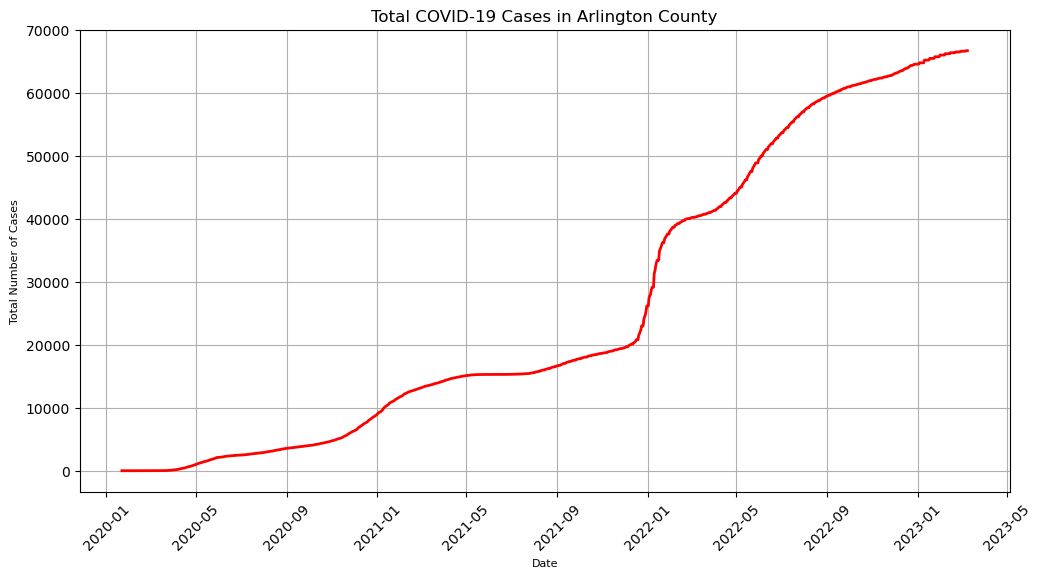

Interactive map of Virginia counties and total COVID-19 cases as of 12/31/2022:


In [31]:
# Project code & output

# Print the report header
print("*** MIS 433 COVID-19 Report ***")

# Get user input for the county
user_county = input("Enter County: ")
state_name = "Virginia"


# Merge cases and deaths data and filter for the specified county and state
df_merge = pd.merge(df_cases, df_deaths[["UID", "Population"]], on="UID", how="left")
df_county = df_merge[(df_merge['Admin2'] == user_county) & (df_merge['Province_State'] == state_name)]

# Calculate the total population of Virginia
population_virginia = df_merge[df_merge['Province_State'] == state_name]['Population'].sum()

# Extract COVID-19 cases data for the specified county
county_cases = df_county.iloc[:, 11:]

# Find the date of the first reported outbreak in the county
first_outbreak_date = county_cases.columns[(county_cases > 0).any(axis=0)][0]
first_outbreak_date = pd.to_datetime(first_outbreak_date, format='%m/%d/%y').strftime('%B %d, %Y')

# Calculate yearly statistics for the specified county
year_columns_2020 = [col for col in df_county.columns if col.endswith("/20")]
if year_columns_2020:
    total_cases_2020 = df_county[year_columns_2020].iloc[0, -1] - df_county[year_columns_2020].iloc[0, 0]
    average_cases_2020 = round(total_cases_2020 / len(year_columns_2020), 2)
else:
    average_cases_2020 = None
    total_cases_2020 = None

year_columns_2021 = [col for col in df_county.columns if col.endswith("/21")]
if year_columns_2021:
    total_cases_2021 = df_county[year_columns_2021].iloc[0, -1] - df_county[year_columns_2021].iloc[0, 0]
    average_cases_2021 = round(total_cases_2021 / len(year_columns_2021), 2)
else:
    average_cases_2021 = None
    total_cases_2021 = None

year_columns_2022 = [col for col in df_county.columns if col.endswith("/22")]
if year_columns_2022:
    total_cases_2022 = df_county[year_columns_2022].iloc[0, -1] - df_county[year_columns_2022].iloc[0, 0]
    average_cases_2022 = round(total_cases_2022 / len(year_columns_2022), 2)
else:
    average_cases_2022 = None
    total_cases_2022 = None
    
# Set cumulative cases date to December 31, 2022
cumulative_cases_date = "December 31, 2022"
if cumulative_cases_date in df_county.columns:
    # Access the first row of the 'cumulative_cases_date' column
    cumulative_total_cases = df_county[cumulative_cases_date].iloc[0]

# Calculate the cumulative total number of cases for the specified county
cumulative_total_cases = df_county.iloc[:, 11:].sum().sum()

# Print the COVID-19 summary statistics for the specified county
print(f"\nPopulation of {user_county}, Virginia: {population_virginia}")
print(f"\nFirst Reported Outbreak in {user_county}: {first_outbreak_date}\n")
print(f"\n{user_county} County COVID-19 Summary Statistics:")
print(f" - Average number of new cases in 2020: {average_cases_2020}")
print(f" - Average number of new cases in 2021: {average_cases_2021}")
print(f" - Average number of new cases in 2022: {average_cases_2022}")
print(f" - Total number of new cases in 2020: {total_cases_2020}")
print(f" - Total number of new cases in 2021: {total_cases_2021}")
print(f" - Total number of new cases in 2022: {total_cases_2022}")
print(f" - Cumulative total number of cases: {cumulative_total_cases} ({cumulative_cases_date})")

# Graphs

# Filter the DataFrame to get data for the specified county and state
county_data = df_cases[(df_cases["Admin2"] == user_county) & (df_cases["Province_State"] == state_name)]

# Extract date columns and transpose the data for time series plotting
date_columns = county_data.columns[11:]
county_timeseries = county_data[date_columns].T.rename_axis('Date').rename({'Total Cases': 'Total Cases'}, axis=1)
county_timeseries.index = pd.to_datetime(county_timeseries.index)

# Plot the time series data
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.plot(county_timeseries, marker="", color="red", linewidth = 2)
plt.ylabel("Total Number of Cases", fontsize = 8)
plt.xlabel("Date", fontsize = 8)
plt.title(f"Total COVID-19 Cases in {user_county} County")
plt.xticks(rotation=45)
plt.show()

#Map

print("Interactive map of Virginia counties and total COVID-19 cases as of 12/31/2022:")

# Filter the DataFrame to get data for Virginia
virginia_df = df_cases[df_cases["Province_State"] == "Virginia"]

# Filter county shapes data for Virginia
virginia_county_shapes = county_shapes[(county_shapes["FIPS_BEA"] >= 51001) & (county_shapes["FIPS_BEA"] <= 53000)]

# Merge county shapes and COVID-19 data for Virginia
virginia_gdf = pd.merge(county_shapes, virginia_df, left_on=["FIPS_BEA"], right_on=["FIPS"])

# Create a new column 'cases' for mapping
virginia_gdf['cases'] = virginia_gdf["12/31/22"]

# Create an interactive map using GeoPandas plotly extension
virginia_map = virginia_gdf.explore(column="cases", cmap="Set2", legend=True, scheme="EqualInterval")
virginia_map
